# Recurrent neighbors from retrospective cohorts
We applied matchmaking to the retrospective cohorts. In this notebook, we look at the results; specifically, which cell lines are recurrent nearest neighbor and what therapies are these cell lines sensitive to. 

In [1]:
import glob
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../common/')
import settings
settings.set_arial_as_font()

from settings import Colors
tableau10 = Colors.tableau10

%matplotlib inline

In [2]:
robinson_handles = glob.glob('../retrospective-cohorts/2015-Robinson/data/almanac/*/*.matchmaker.txt')
vanallen_handles = glob.glob('../retrospective-cohorts/2015-VanAllen/data/almanac/*/*.matchmaker.txt')
kirp_handles = glob.glob('../retrospective-cohorts/2016-TCGA/data/almanac/*/*.matchmaker.txt')
os_handles = glob.glob('../retrospective-cohorts/2014-Perry/data/almanac/*/*.matchmaker.txt')

summary = pd.read_csv('formatted/cell-lines.summary.txt', sep='\t')
zscores = pd.read_csv('formatted/sanger.gdsc.txt', sep='\t')

broad_to_ccle_map = summary.set_index('broad')['ccle_name'].dropna().to_dict()
sanger_to_ccle_map = summary.set_index('sanger')['ccle_name'].dropna().to_dict()

zscores['ccle_name'] = zscores['model_id'].replace(sanger_to_ccle_map)
zscores_map = {}
for label, group in zscores[zscores['z_score'].le(-2)].groupby('ccle_name'):
    zscores_map[label] = ', '.join(group['therapy_name'].sort_values().tolist())
    
zscores_most_sensitive_map = {}
for label, group in zscores.groupby('ccle_name'):
    sensitive_group = group[group['z_score'].le(-2)]
    if sensitive_group.shape[0] == 0:
        therapy = 'None'
    else:
        therapy = group.sort_values('z_score', ascending=True)['therapy_name'].tolist()[0]
    zscores_most_sensitive_map[label] = therapy
    
fda = pd.read_csv('tables/features/fda-features.boolean.txt', sep='\t')

In [3]:
zscores['model_id'].drop_duplicates().shape

(988,)

In [4]:
zscores[zscores['z_score'].le(-2)]['model_id'].drop_duplicates().shape

(856,)

In [5]:
pd.DataFrame.from_dict(zscores_most_sensitive_map, orient='index')[0].value_counts()

None                  132
CAY10566               23
IAP_7638               19
Cetuximab              17
SB590885               17
                     ... 
Serdemetan              1
Obatoclax Mesylate      1
I-BET-762               1
MIM1                    1
CGP-60474               1
Name: 0, Length: 213, dtype: int64

## Functions

In [6]:
def plot_individual_bar(dataframe, title, color, folder, filename, size_x=7.5, size_y=7.5):
    fig = plt.figure(constrained_layout=True, figsize=(size_x, size_y))
    ax = plt.subplot()
    remove_spines(ax)
    
    p1 = dataframe.value_counts().plot(kind='bar', color=color)
    plt.title(title, fontsize=20)
    
    plt.xticks(fontsize=14, rotation=45, ha='right')
    plt.yticks(fontsize=18)
    
    plt.xlim([-1, 10.5])
    
    for suffix in ['svg', 'png']:
        outname = f'../../figures/{folder}/{filename}.{suffix}'
        plt.savefig(outname, format=suffix)
    
    return fig

def plot_vertical_bar_pair(dataframe1, title1, color1, dataframe2, title2, color2, folder, filename):
    fig = plt.figure(constrained_layout=True, figsize=(7.5, 10))
    spec = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
    
    ax0 = fig.add_subplot(spec[0, 0])
    p1 = dataframe1.value_counts().plot(kind='bar', color=color1)
    plt.title(title1, fontsize=20)
    
    plt.xticks(fontsize=14, rotation=45, ha='right')
    plt.yticks(fontsize=18)
    plt.xlim([-1, 10.5])
    
    ax1 = fig.add_subplot(spec[1, 0])
    p1 = dataframe2.value_counts().plot(kind='bar', color=color2)
    plt.title(title2, fontsize=20)
    
    plt.xticks(fontsize=14, rotation=45, ha='right')
    plt.yticks(fontsize=18)
    plt.xlim([-1, 10.5])
    
    for ax in [ax0, ax1]:
        remove_spines(ax) 
    return fig
    
def remove_spines(axis):
    axis.spines["top"].set_visible(False)    
    axis.spines["bottom"].set_visible(False)    
    axis.spines["right"].set_visible(False)    
    axis.spines["left"].set_visible(False)
    
def remove_ticks():
    plt.tick_params(axis = 'both', which = 'both',
                top = False, bottom = False, right = False, left = False, 
                labeltop = False, labelbottom = True, labelright = False, labelleft = True)

def create_data_table(dataframe, name_map, zscores_map, zscore_most_sensitive_dict):
    df = (dataframe
          .reset_index()
          .sort_values(['SNF: FDA & CGC'], ascending=True)
          .drop_duplicates('case', keep='first')
         )
    df['ccle_name'] = df['comparison'].replace(name_map)
    df['nearest neighbor sensitive therapies'] = df['ccle_name'].map(zscores_map).fillna('None')
    df['nearest neighbor most sensitive therapy'] = df['ccle_name'].map(zscore_most_sensitive_dict).fillna('None')
    return df

#def write_data_table(dataframe, folder_name, file_name):
#    dataframe.to_excel(f'../../figures/{folder_name}/{file_name}.xlsx', index=False)

## Metastatic castration resistant prostate cancer

In [7]:
title1 = 'Nearest neighbor cell lines to\nmCRPC profiles (n=150)'
title2 = 'Recurrent therapeutic sensitivities for nearest neighbor\ncell line to mCRPC profiles (n=150)'
folder_name = 'supplementary-figure-08'
file_name = 'supplementary-figure-8'

df = pd.concat([pd.read_csv(handle, sep='\t', index_col=0) for handle in robinson_handles])
df = df[~df['comparison'].eq('case-profile')]
df.sort_values(['SNF: FDA & CGC'], ascending=True, inplace=True)

first_neighbors = []
for label, group in df.groupby('case'):
    first_neighbors.append(group['comparison'].replace(broad_to_ccle_map).tolist()[0])
first_neighbors = pd.Series(first_neighbors)

first_neighbor_therapies = []
for sample in first_neighbors.tolist():
    list_ = zscores[zscores['ccle_name'].eq(sample) & zscores['z_score'].le(-2)]['therapy_name']
    first_neighbor_therapies.append(pd.Series(list_))
first_neighbor_therapies = pd.concat(first_neighbor_therapies, ignore_index=True)

print(first_neighbors.value_counts().head(10))
print('')

print(first_neighbor_therapies.value_counts().head(10))
print('')

first_neighbors = first_neighbors.str.replace('_', ' ').apply(lambda x: ' ('.join(x.split(" ", 1))) + ')'
first_neighbors = first_neighbors.str.replace('CENTRAL NERVOUS SYSTEM', 'CNS')
data_table = create_data_table(df, broad_to_ccle_map, zscores_map, zscores_most_sensitive_map)

prostate_therapies = first_neighbor_therapies
prostate_neighbors = first_neighbors
prostate_table = data_table

VCAP_PROSTATE                   23
A498_KIDNEY                      8
NCIH2196_LUNG                    7
SNB75_CENTRAL_NERVOUS_SYSTEM     5
UO31_KIDNEY                      4
GMS10_CENTRAL_NERVOUS_SYSTEM     4
HS578T_BREAST                    4
HCC1428_BREAST                   3
T24_URINARY_TRACT                3
HCC1500_BREAST                   3
dtype: int64

Acetalax          33
UNC0642           29
SB52334           29
Selisistat        25
Linsitinib        24
Trichostatin A    23
CHIR-99021        22
AZD8186           12
MCT4_1422         11
IAP_7638          11
Name: therapy_name, dtype: int64



In [8]:
data_table.head()

,case,comparison,SNF: FDA & CGC,ccle_name,nearest neighbor sensitive therapies,nearest neighbor most sensitive therapy
0,SC_9047,ACH-000548,0.995660,BHY_UPPER_AERODIGESTIVE_TRACT,"AST-1306, WHI-P97",WHI-P97
1,SC_9080,ACH-000282,0.995865,NCIH1755_LUNG,"AKT inhibitor VIII, Avagacestat, BPD-00008900,...",GW-2580
3,MO_1162,ACH-000399,0.995885,NCIH2196_LUNG,TL-2-105,TL-2-105
4,PROS01448-1115183,ACH-000399,0.995926,NCIH2196_LUNG,TL-2-105,TL-2-105
5,SC_9089,ACH-000399,0.995954,NCIH2196_LUNG,TL-2-105,TL-2-105


## Metastatic melanoma

In [9]:
title1 = 'Nearest neighbor cell lines\nto metastatic melanoma profiles (n=110)'
title2 = 'Recurrent therapeutic sensitivities for nearest neighbor\ncell line to metastatic melanoma profiles (n=110)'
folder_name = 'figure-03-c'
file_name = 'figure-3-c'

df = pd.concat([pd.read_csv(handle, sep='\t', index_col=0) for handle in vanallen_handles])
df = df[~df['comparison'].eq('case-profile')]
df.sort_values(['SNF: FDA & CGC'], ascending=True, inplace=True)

first_neighbors = []
for label, group in df.groupby('case'):
    first_neighbors.append(group['comparison'].replace(broad_to_ccle_map).tolist()[0])
first_neighbors = pd.Series(first_neighbors)

first_neighbor_therapies = []
for sample in first_neighbors.tolist():
    list_ = zscores[zscores['ccle_name'].eq(sample) & zscores['z_score'].le(-2)]['therapy_name']
    first_neighbor_therapies.append(pd.Series(list_))
first_neighbor_therapies = pd.concat(first_neighbor_therapies, ignore_index=True)

print(first_neighbors.value_counts().head(10))
print('')

print(first_neighbor_therapies.value_counts().head(10))
print('')

first_neighbors = first_neighbors.str.replace('_', ' ').apply(lambda x: ' ('.join(x.split(" ", 1))) + ')'
first_neighbors = first_neighbors.str.replace('CENTRAL NERVOUS SYSTEM', 'CNS')
data_table = create_data_table(df, broad_to_ccle_map, zscores_map, zscores_most_sensitive_map)

melanoma_therapies = first_neighbor_therapies
melanoma_neighbors = first_neighbors
melanoma_table = data_table

SKHEP1_LIVER                        7
HT144_SKIN                          5
A375_SKIN                           5
GCT_SOFT_TISSUE                     3
SNU175_LARGE_INTESTINE              3
SH4_SKIN                            3
GMS10_CENTRAL_NERVOUS_SYSTEM        3
KALS1_CENTRAL_NERVOUS_SYSTEM        3
DBTRG05MG_CENTRAL_NERVOUS_SYSTEM    3
CAOV4_OVARY                         3
dtype: int64

SB590885             22
Dabrafenib           19
PD0325901            14
PLX-4720             14
(5Z)-7-Oxozeaenol    14
RAF_9304             13
CHIR-99021           13
Refametinib          12
MCT4_1422            12
CI-1040              11
Name: therapy_name, dtype: int64



In [10]:
data_table.head()

,case,comparison,SNF: FDA & CGC,ccle_name,nearest neighbor sensitive therapies,nearest neighbor most sensitive therapy
0,MEL-IPI_Pat78,ACH-000322,0.994157,HT144_SKIN,"(5Z)-7-Oxozeaenol, AZ628, CGP-082996, Dabrafen...",SB590885
1,MEL-IPI_Pat128,ACH-000322,0.994188,HT144_SKIN,"(5Z)-7-Oxozeaenol, AZ628, CGP-082996, Dabrafen...",SB590885
2,MEL-IPI_Pat14,ACH-000322,0.994392,HT144_SKIN,"(5Z)-7-Oxozeaenol, AZ628, CGP-082996, Dabrafen...",SB590885
3,MEL-IPI_Pat86,ACH-000863,0.994431,DBTRG05MG_CENTRAL_NERVOUS_SYSTEM,None,None
4,MEL-IPI_Pat49,ACH-000863,0.994746,DBTRG05MG_CENTRAL_NERVOUS_SYSTEM,None,None


### What % of melanomas have a nearest neighbor that is melanoma / SKIN

In [11]:
first_neighbors.str.contains('SKIN').value_counts()

False    84
True     26
dtype: int64

### What % of melanomas have a nearest neighbor that is p.V600E positive?

In [12]:
summary['ccle_spaces'] = summary['ccle_name'].str.replace('(', '').str.replace(')', '').str.replace('_', ' ')
name_map = (summary
            .loc[:, ['broad', 'ccle_spaces']]
            .dropna()
            .set_index('broad')
            .to_dict()['ccle_spaces']
           )

v600e_cell_lines = fda.loc[fda['BRAF p.V600E'].eq(1), 'model_id']
v600e_cell_lines.head(2)

2     ACH-000008
12    ACH-000052
Name: model_id, dtype: object

In [13]:
first_neighbors.head(2)

0     SKHEP1 (LIVER)
1    DBTRG05MG (CNS)
dtype: object

In [14]:
(first_neighbors
 .str.replace('(', '')
 .str.replace(')', '')
 .isin(v600e_cell_lines.replace(name_map))
).value_counts()

False    74
True     36
dtype: int64

In [15]:
retrospective = pd.read_csv('../retrospective-cohorts/retrospective.actionability.txt', sep='\t')
retrospective.loc[retrospective['cohort'].eq('MEL') & retrospective['feature_string'].eq('BRAF.p.V600E'), :].shape

(39, 12)

In [16]:
data_table['nearest neighbor most sensitive therapy'].value_counts().head()

SB590885      15
None          12
AGI-5198       7
CHIR-99021     5
FTI-277        4
Name: nearest neighbor most sensitive therapy, dtype: int64

## Papillary renal cell carcinoma

In [17]:
title1 = 'Nearest neighbor cell lines to\nKIRP profiles (n=100)'
title2 = 'Recurrent therapeutic sensitivities for nearest neighbor\ncell line to KIRP profiles (n=100)'

folder_name = 'supplementary-figure-09'
file_name = 'supplementary-figure-09'

df = pd.concat([pd.read_csv(handle, sep='\t', index_col=0) for handle in kirp_handles])
df = df[~df['comparison'].eq('case-profile')]
df.sort_values(['SNF: FDA & CGC'], ascending=True, inplace=True)

first_neighbors = []
for label, group in df.groupby('case'):
    first_neighbors.append(group['comparison'].replace(broad_to_ccle_map).tolist()[0])
first_neighbors = pd.Series(first_neighbors)

first_neighbor_therapies = []
for sample in first_neighbors.tolist():
    list_ = zscores[zscores['ccle_name'].eq(sample) & zscores['z_score'].le(-2)]['therapy_name']
    first_neighbor_therapies.append(pd.Series(list_))
first_neighbor_therapies = pd.concat(first_neighbor_therapies, ignore_index=True)

print(first_neighbors.value_counts().head(10))
print('')

print(first_neighbor_therapies.value_counts().head(10))
print('')

first_neighbors = first_neighbors.str.replace('_', ' ').apply(lambda x: ' ('.join(x.split(" ", 1))) + ')'
first_neighbors = first_neighbors.str.replace('CENTRAL NERVOUS SYSTEM', 'CNS')
first_neighbors = first_neighbors.str.replace('AUTONOMIC GANGLIA', 'NBS')
data_table = create_data_table(df, broad_to_ccle_map, zscores_map, zscores_most_sensitive_map)

renal_therapies = first_neighbor_therapies
renal_neighbors = first_neighbors
renal_table = data_table

MOGGCCM_CENTRAL_NERVOUS_SYSTEM    10
G361_SKIN                          7
GMS10_CENTRAL_NERVOUS_SYSTEM       6
CAL54_KIDNEY                       5
MHHNB11_AUTONOMIC_GANGLIA          5
UO31_KIDNEY                        4
NCIH1048_LUNG                      4
SIMA_AUTONOMIC_GANGLIA             4
SKHEP1_LIVER                       4
CAKI1_KIDNEY                       4
dtype: int64

IAP_7638       13
MCT4_1422      12
CHIR-99021     12
TANK_1366      10
LFM-A13         9
Dabrafenib      8
AZD5582         8
Refametinib     8
IAP_5620        8
AGI-5198        8
Name: therapy_name, dtype: int64



In [18]:
data_table.head()

,case,comparison,SNF: FDA & CGC,ccle_name,nearest neighbor sensitive therapies,nearest neighbor most sensitive therapy
0,KIRP-A4-7997,ACH-000563,0.994616,EBC1_LUNG,"AZD3514, AZD6094, BPTES, Bicalutamide, Cabozan...",AZD6094
1,KIRP-A4-7287,ACH-000242,0.995442,RT4_URINARY_TRACT,"FGFR_0939, IRAK4_4710, PD173074, TAF1_5496",IRAK4_4710
2,KIRP-5P-A9KC,ACH-000428,0.996060,UO31_KIDNEY,"AZD3514, Bleomycin (10 uM), Bleomycin (50 uM),...",UNC0642
3,KIRP-AL-3468,ACH-000040,0.996163,U118MG_CENTRAL_NERVOUS_SYSTEM,"Fludarabine, Rucaparib",Fludarabine
10,KIRP-A4-A5DU,ACH-001125,0.996526,MOGGCCM_CENTRAL_NERVOUS_SYSTEM,None,None


## Osteosarcoma

In [19]:
title1 = 'Nearest neighbor cell lines to\nOS profiles (n=59)'
title2 = 'Recurrent therapeutic sensitivities for nearest neighbor\ncell line to OS profiles (n=59)'

folder_name = 'supplementary-figure-10'
file_name = 'supplementary-figure-10'

df = pd.concat([pd.read_csv(handle, sep='\t', index_col=0) for handle in os_handles])
df = df[~df['comparison'].eq('case-profile')]
df.sort_values(['SNF: FDA & CGC'], ascending=True, inplace=True)

first_neighbors = []
for label, group in df.groupby('case'):
    first_neighbors.append(group['comparison'].replace(broad_to_ccle_map).tolist()[0])
first_neighbors = pd.Series(first_neighbors)

first_neighbor_therapies = []
for sample in first_neighbors.tolist():
    list_ = zscores[zscores['ccle_name'].eq(sample) & zscores['z_score'].le(-2)]['therapy_name']
    first_neighbor_therapies.append(pd.Series(list_))
first_neighbor_therapies = pd.concat(first_neighbor_therapies, ignore_index=True)

print(first_neighbors.value_counts().head(10))
print('')

print(first_neighbor_therapies.value_counts().head(10))
print('')

first_neighbors = first_neighbors.str.replace('_', ' ').apply(lambda x: ' ('.join(x.split(" ", 1))) + ')'
first_neighbors = first_neighbors.str.replace('CENTRAL NERVOUS SYSTEM', 'CNS')
first_neighbors = first_neighbors.str.replace('AUTONOMIC GANGLIA', 'NBS')
data_table = create_data_table(df, broad_to_ccle_map, zscores_map, zscores_most_sensitive_map)

osteosarcoma_therapies = first_neighbor_therapies
osteosarcoma_neighbors = first_neighbors
osteosarcoma_table = data_table

SKHEP1_LIVER                     9
U118MG_CENTRAL_NERVOUS_SYSTEM    3
SKNSH_AUTONOMIC_GANGLIA          3
GMS10_CENTRAL_NERVOUS_SYSTEM     2
SNB75_CENTRAL_NERVOUS_SYSTEM     2
U87MG_CENTRAL_NERVOUS_SYSTEM     2
VCAP_PROSTATE                    2
T98G_CENTRAL_NERVOUS_SYSTEM      2
ISTMES1_PLEURA                   2
TE441T_SOFT_TISSUE               2
dtype: int64

SN-38           10
AGI-5198         9
CHIR-99021       5
Fludarabine      5
AST-1306         5
AZD6094          4
AZD1332          4
Bicalutamide     4
Pilaralisib      3
Amuvatinib       3
Name: therapy_name, dtype: int64



In [20]:
data_table.head()

,case,comparison,SNF: FDA & CGC,ccle_name,nearest neighbor sensitive therapies,nearest neighbor most sensitive therapy
0,Osteosarcoma-JNS538,ACH-000867,0.995739,CHAGOK1_LUNG,CCT007093,CCT007093
2,Osteosarcoma-BCS514,ACH-000225,0.996522,ECC12_STOMACH,None,None
6,Osteosarcoma-VMO265,ACH-000755,0.996670,HCC2218_BREAST,"AST-1306, Afatinib, Amuvatinib, BAM7, CI-1033,...",CP724714
11,Osteosarcoma-MSF790,ACH-000148,0.997014,HS578T_BREAST,"AT7867, BI-2536, JQ1, KIN001-042, LIMK1 inhibi...",Pilaralisib
12,Osteosarcoma-IVSS621,ACH-000570,0.997033,YKG1_CENTRAL_NERVOUS_SYSTEM,Bryostatin 1,Bryostatin 1


## Create figure
All four cohorts will be placed side by side for Fig. 4c.

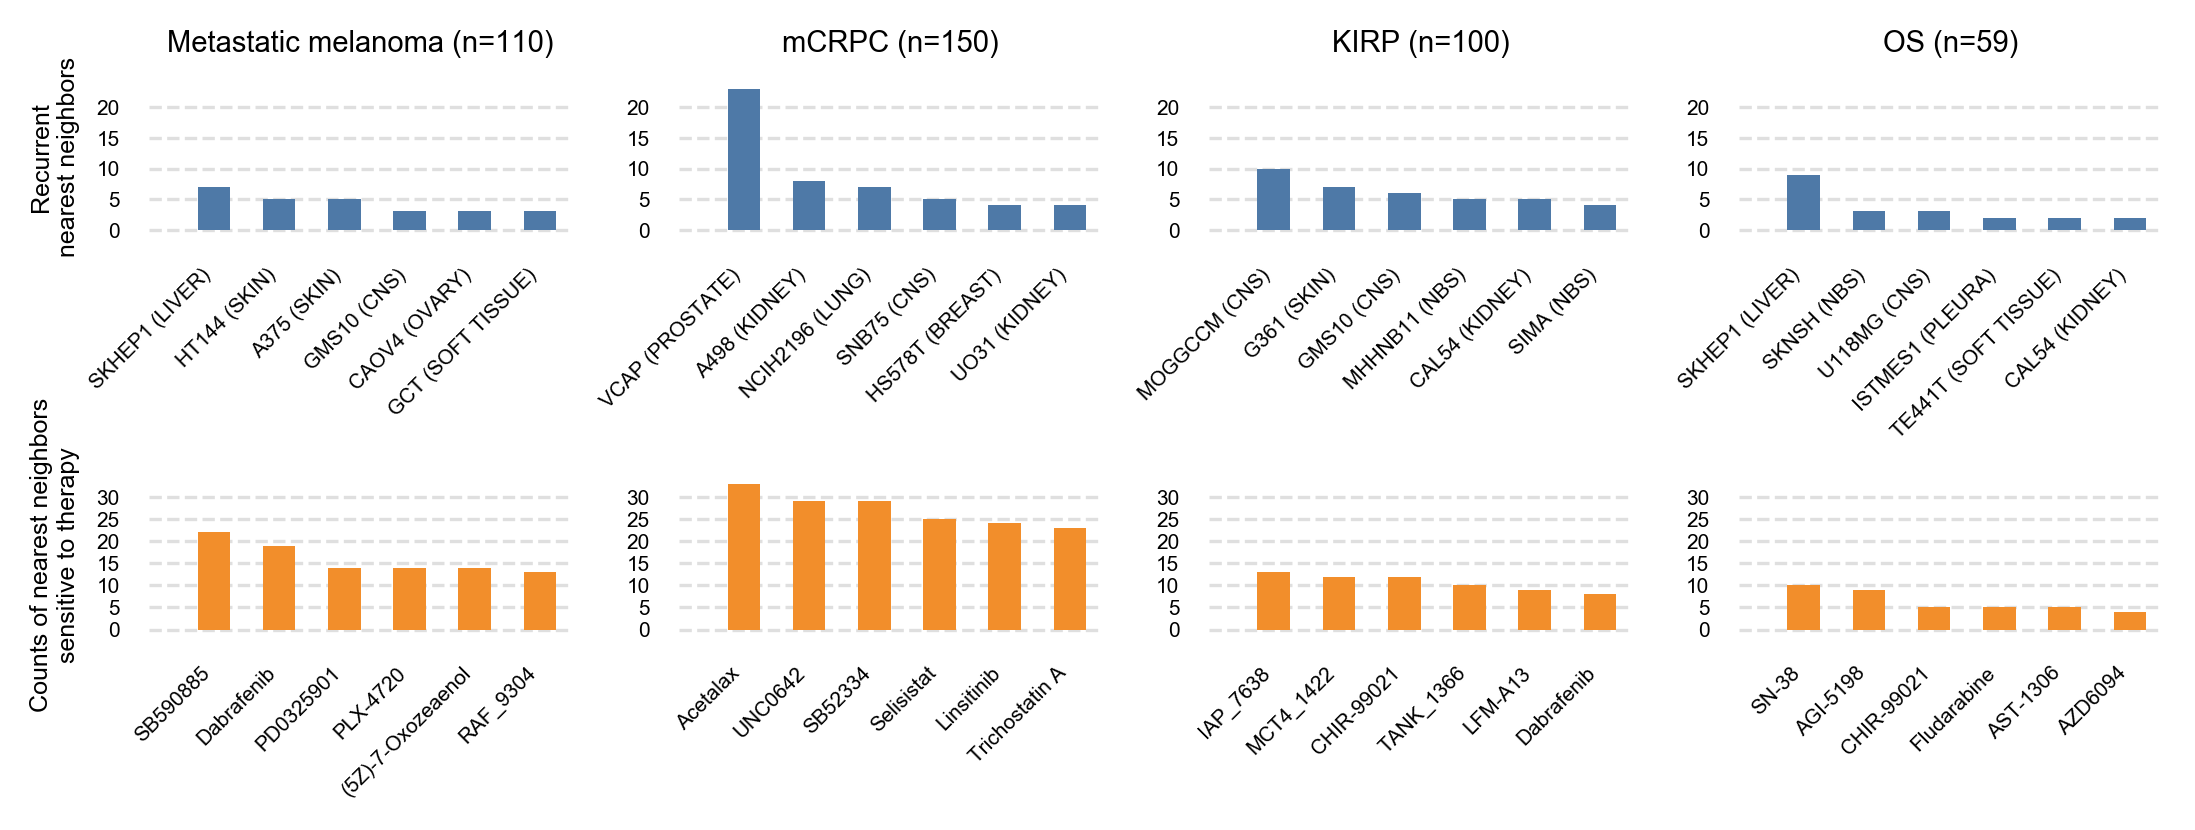

In [21]:
def plot_bar(spec_x, spec_y, dataframe, title, color, ymax, yticks, ylabel=''):
    ax = fig.add_subplot(gs[spec_x, spec_y])
    p = dataframe.value_counts().plot(kind='bar', color=color, zorder=3)
    plt.grid(True, linestyle='--', alpha=0.25, color='grey', axis='y')
    plt.title(title, fontsize=7)
    plt.xticks(fontsize=5, rotation=45, ha='right')
    plt.yticks(fontsize=5)
    plt.xlim([-1, 5.5])
    plt.ylim([-1, ymax])
    remove_spines(ax)
    plt.yticks(yticks)
    remove_ticks()
    if ylabel != '':
        plt.ylabel(ylabel, fontsize=6)
    return p

cm = 1/2.54
fig = plt.figure(figsize=(22*cm, 6.25*cm), dpi=300)

width_ratios = [1, 0.25, 1, 0.25, 1, 0.25, 1]
height_ratios = [1, 1.5, 1]
gs = gridspec.GridSpec(3, 7, width_ratios = width_ratios, height_ratios=height_ratios, hspace=0, wspace=0)

def neighbor_title(ontology, n):
    return f"Nearest neighbor cell lines\nto {ontology} profiles (n={n})"

def therapy_title(ontology, n):
    return f"Recurrent therapeutic sensitivites for nearest neighbor\ncell lines to {ontology} profiles (n={n})"

p00 = plot_bar(0, 0, melanoma_neighbors, 'Metastatic melanoma (n=110)', tableau10['blue'], 25, [0, 5, 10, 15, 20], 
               ylabel='Recurrent\nnearest neighbors')
p20 = plot_bar(2, 0, melanoma_therapies, '', tableau10['orange'], 35, [0, 5, 10, 15, 20, 25, 30],
               ylabel='Counts of nearest neighbors\nsensitive to therapy')

p02 = plot_bar(0, 2, prostate_neighbors, 'mCRPC (n=150)', tableau10['blue'], 25, [0, 5, 10, 15, 20])
p22 = plot_bar(2, 2, prostate_therapies, '', tableau10['orange'], 35, [0, 5, 10, 15, 20, 25, 30])

p04 = plot_bar(0, 4, renal_neighbors, 'KIRP (n=100)', tableau10['blue'], 25, [0, 5, 10, 15, 20])
p24 = plot_bar(2, 4, renal_therapies, '', tableau10['orange'], 35, [0, 5, 10, 15, 20, 25, 30])

p06 = plot_bar(0, 6, osteosarcoma_neighbors, 'OS (n=59)', tableau10['blue'], 25, [0, 5, 10, 15, 20])
p26 = plot_bar(2, 6, osteosarcoma_therapies, '', tableau10['orange'], 35, [0, 5, 10, 15, 20, 25, 30])

filename = 'fig-5-c'
folder = f'../../figures/fig-5/fig-5-c'
!mkdir -p $folder
for suffix in ['eps', 'pdf', 'png', 'svg']:
    outname = f'{folder}/{filename}.{suffix}'
    plt.savefig(outname, format=suffix, bbox_inches='tight', dpi=300)

plt.show()

In [22]:
writer = pd.ExcelWriter(f'{folder}/source-data-{filename}.xlsx', engine='xlsxwriter')
melanoma_table.to_excel(writer, index=False, sheet_name='Fig. 5c - melanoma')
prostate_table.to_excel(writer, index=False, sheet_name='Fig. 5c - mCRPC')
renal_table.to_excel(writer, index=False, sheet_name='Fig. 5c - KIRP')
osteosarcoma_table.to_excel(writer, index=False, sheet_name='Fig. 5c - OS')
writer.save()